In [1]:
import torch
import math
import matplotlib.pyplot as plt

from PIL import Image
from diffusers import FluxPipeline
from torch import Tensor
from torchvision import transforms

DTYPE = torch.bfloat16
pipe = FluxPipeline.from_pretrained("/root/autodl-tmp/Flux-dev", torch_dtype=DTYPE) # NOTE: change this to the path of the model
pipe.to("cuda")

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.31.0.dev0",
  "_name_or_path": "/root/autodl-tmp/Flux-dev",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [2]:
@torch.inference_mode()
def decode_imgs(latents, pipeline):
    imgs = (latents / pipeline.vae.config.scaling_factor) + pipeline.vae.config.shift_factor
    imgs = pipeline.vae.decode(imgs)[0]
    imgs = pipeline.image_processor.postprocess(imgs, output_type="pil")
    return imgs

@torch.inference_mode()
def encode_imgs(imgs, pipeline):
    latents = pipeline.vae.encode(imgs).latent_dist.sample()
    latents = (latents - pipeline.vae.config.shift_factor) * pipeline.vae.config.scaling_factor
    latents = latents.to(dtype=DTYPE)
    return latents

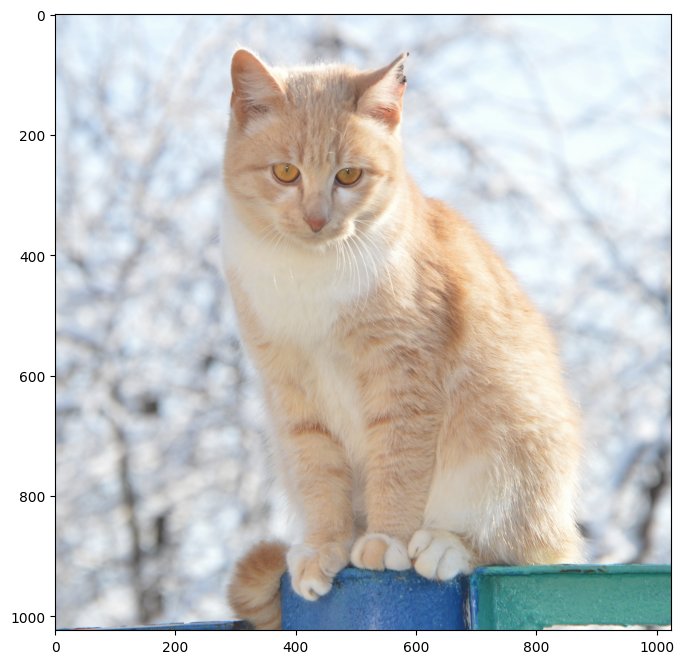

In [4]:
img = Image.open("./example/cat.png")

train_transforms = transforms.Compose(
            [
                transforms.Resize(1024, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(1024),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

img = train_transforms(img).unsqueeze(0).to("cuda").to(DTYPE)

img_latent = encode_imgs(img, pipe)
img_rec = decode_imgs(img_latent, pipe)[0]

plt.figure(figsize=(8, 8))
plt.imshow(img_rec)

In [5]:
def get_schedule(
    num_steps: int,
    image_seq_len: int,
    base_shift: float = 0.5,
    max_shift: float = 1.15,
    shift: bool = True,
) -> list:
    def get_lin_function(
        x1: float = 256, y1: float = 0.5, x2: float = 4096, y2: float = 1.15
    ):
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        return lambda x: m * x + b
    def time_shift(mu: float, sigma: float, t: Tensor):
        return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)
    
    # extra step for zero
    timesteps = torch.linspace(1, 0, num_steps + 1, dtype=torch.float32)

    # shifting the schedule to favor high timesteps for higher signal images
    if shift:
        # estimate mu based on linear estimation between two points
        mu = get_lin_function(y1=base_shift, y2=max_shift)(image_seq_len)
        timesteps = time_shift(mu, 1.0, timesteps)

    return timesteps.tolist()

In [7]:
@torch.inference_mode()
def interpolated_inversion(
    pipeline, 
    latents,
    gamma,
    DTYPE,
    num_steps=28,
    use_shift_t_sampling=False, 
):
    timesteps = get_schedule( 
                num_steps=num_steps,
                image_seq_len=(1024 // 16) * (1024 // 16), # vae_scale_factor = 16
                shift=use_shift_t_sampling,  # Set True for Flux-dev, False for Flux-schnell
            )[::-1] # flipped for inversion
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt( # null text
        prompt="", 
        prompt_2=""
    )
    latent_image_ids = pipeline._prepare_latent_image_ids(
        latents.shape[0],
        latents.shape[2],
        latents.shape[3],
        latents.device, 
        DTYPE,
    )
    packed_latents = pipeline._pack_latents(
        latents,
        batch_size=latents.shape[0],
        num_channels_latents=latents.shape[1],
        height=latents.shape[2],
        width=latents.shape[3],
    )
    
    target_noise = torch.randn(packed_latents.shape, device=packed_latents.device, dtype=torch.float32)
    guidance_scale=0.0 # zero guidance for inversion
    guidance_vec = torch.full((packed_latents.shape[0],), guidance_scale, device=packed_latents.device, dtype=packed_latents.dtype)

    # Image inversion with interpolated velocity field.  t goes from 0.0 to 1.0
    with pipeline.progress_bar(total=len(timesteps)-1) as progress_bar:
        for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
            t_vec = torch.full((packed_latents.shape[0],), t_curr, dtype=packed_latents.dtype, device=packed_latents.device)

            # Null text velocity
            flux_velocity = pipeline.transformer(
                    hidden_states=packed_latents,
                    timestep=t_vec,
                    guidance=guidance_vec,
                    pooled_projections=pooled_prompt_embeds,
                    encoder_hidden_states=prompt_embeds,
                    txt_ids=text_ids,
                    img_ids=latent_image_ids,
                    joint_attention_kwargs=None,
                    return_dict=pipeline,
                )[0]
            
            # Prevents precision issues
            packed_latents = packed_latents.to(torch.float32)
            flux_velocity = flux_velocity.to(torch.float32)

            # Target noise velocity
            target_noise_velocity = (target_noise - packed_latents) / (1.0 - t_curr)
            
            # interpolated velocity
            interpolated_velocity = gamma * target_noise_velocity + (1 - gamma) * flux_velocity
            
            # one step Euler
            packed_latents = packed_latents + (t_prev - t_curr) * interpolated_velocity
            
            packed_latents = packed_latents.to(DTYPE)
            progress_bar.update()
            
    print("Mean Absolute Error", torch.mean(torch.abs(packed_latents - target_noise)))
    
    latents = pipeline._unpack_latents(
            packed_latents,
            height=1024,
            width=1024,
            vae_scale_factor=pipeline.vae_scale_factor,
    )
    latents = latents.to(DTYPE)
    return latents

gamma = 0.5
img_latent_inv = interpolated_inversion(pipe, img_latent, gamma, DTYPE)

  0%|          | 0/28 [00:00<?, ?it/s]

Mean Absolute Error tensor(0.0586, device='cuda:0')


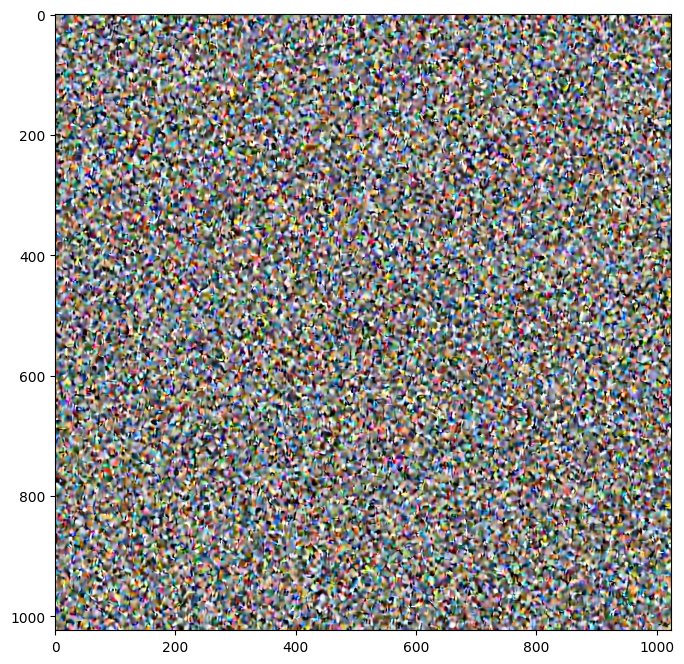

In [8]:
img = decode_imgs(img_latent_inv, pipe)[0]

plt.figure(figsize=(8, 8))
plt.imshow(img)

In [9]:
def generate_eta_values(
    timesteps, 
    start_step, 
    end_step, 
    eta, 
    eta_trend,
):
    # timesteps are monotonically decreasing, from 1.0 to 0.0
    eta_values = [0.0] * (len(timesteps) - 1)
    
    if eta_trend == 'constant':
        for i in range(start_step, end_step):
            eta_values[i] = eta
    elif eta_trend == 'linear_increase':
        total_time = timesteps[start_step] - timesteps[end_step - 1]
        for i in range(start_step, end_step):
            eta_values[i] = eta * (timesteps[start_step] - timesteps[i]) / total_time
    elif eta_trend == 'linear_decrease':
        total_time = timesteps[start_step] - timesteps[end_step - 1]
        for i in range(start_step, end_step):
            eta_values[i] = eta * (timesteps[i] - timesteps[end_step - 1]) / total_time
    else:
        raise NotImplementedError(f"Unsupported eta_trend: {eta_trend}")
    
    return eta_values

@torch.inference_mode()
def interpolated_denoise(
    pipeline, 
    img_latents,
    eta_base,                    # base eta value
    eta_trend,                   # constant, linear_increase, linear_decrease
    start_step,                  # 0-based indexing, closed interval
    end_step,                    # 0-based indexing, open interval
    inversed_latents,            # can be none if not using inversed latents
    use_inversed_latents=True,
    guidance_scale=3.5,
    prompt='photo of a tiger',
    DTYPE=torch.bfloat16,
    num_steps=28,
    use_shift_t_sampling=True, 
):
    timesteps = get_schedule(
    				num_steps=num_steps,
    				image_seq_len=(1024 // 16) * (1024 // 16), # vae_scale_factor = 16
    				shift=use_shift_t_sampling,
    			)
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
        prompt=prompt, 
        prompt_2=prompt
    )
    latent_image_ids = pipeline._prepare_latent_image_ids(
        inversed_latents.shape[0],
        inversed_latents.shape[2],
        inversed_latents.shape[3],
        inversed_latents.device,
        DTYPE,
    )
    if use_inversed_latents:
        packed_latents = pipeline._pack_latents(
            inversed_latents,
            batch_size=inversed_latents.shape[0],
            num_channels_latents=inversed_latents.shape[1],
            height=inversed_latents.shape[2],
            width=inversed_latents.shape[3],
        )
    else:
        tmp_latents = torch.randn_like(img_latents)
        packed_latents = pipeline._pack_latents(
            tmp_latents,
            batch_size=tmp_latents.shape[0],
            num_channels_latents=tmp_latents.shape[1],
            height=tmp_latents.shape[2],
            width=tmp_latents.shape[3],
        )

    packed_img_latents = pipeline._pack_latents(
        img_latents,
        batch_size=img_latents.shape[0],
        num_channels_latents=img_latents.shape[1],
        height=img_latents.shape[2],
        width=img_latents.shape[3],
    )
    
    target_img = packed_img_latents.clone().to(torch.float32)
    guidance_vec = torch.full((packed_latents.shape[0],), guidance_scale, device=packed_latents.device, dtype=packed_latents.dtype)

    eta_values = generate_eta_values(timesteps, start_step, end_step, eta_base, eta_trend)

    # Denoising with interpolated velocity field.  t goes from 1.0 to 0.0
    with pipeline.progress_bar(total=len(timesteps)-1) as progress_bar:
        for idx, (t_curr, t_prev) in enumerate(zip(timesteps[:-1], timesteps[1:])):
            t_vec = torch.full((packed_latents.shape[0],), t_curr, dtype=packed_latents.dtype, device=packed_latents.device)
            
            # Editing text velocity
            flux_velocity = pipeline.transformer(
                    hidden_states=packed_latents,
                    timestep=t_vec,
                    guidance=guidance_vec,
                    pooled_projections=pooled_prompt_embeds,
                    encoder_hidden_states=prompt_embeds,
                    txt_ids=text_ids,
                    img_ids=latent_image_ids,
                    joint_attention_kwargs=None,
                    return_dict=pipeline,
                )[0]
            
            # Prevents precision issues
            packed_latents = packed_latents.to(torch.float32)
            flux_velocity = flux_velocity.to(torch.float32)

            # Target image velocity
            target_img_velocity = -(target_img - packed_latents) / t_curr
            
            # interpolated velocity
            eta = eta_values[idx]
            interpolated_velocity = eta * target_img_velocity + (1 - eta) * flux_velocity
            packed_latents = packed_latents + (t_prev - t_curr) * interpolated_velocity
            print(f"X_{t_prev:.3f} = X_{t_curr:.3f} + {t_prev - t_curr:.3f} * ({eta:3f} * target_img_velocity + {1 - eta:.3f} * flux_velocity)")
            
            packed_latents = packed_latents.to(DTYPE)
            progress_bar.update()
    
    latents = pipeline._unpack_latents(
            packed_latents,
            height=1024,
            width=1024,
            vae_scale_factor=pipeline.vae_scale_factor,
    )
    latents = latents.to(DTYPE)
    return latents

eta_base = 0.7
eta_trend = 'constant'
start_step = 0
end_step = 8
img_latent_denoised = interpolated_denoise(pipe, img_latent, eta_base, eta_trend, start_step, end_step, img_latent_inv)

  0%|          | 0/28 [00:00<?, ?it/s]

X_0.988 = X_1.000 + -0.012 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.976 = X_0.988 + -0.012 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.963 = X_0.976 + -0.013 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.950 = X_0.963 + -0.014 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.936 = X_0.950 + -0.014 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.921 = X_0.936 + -0.015 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.905 = X_0.921 + -0.016 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.888 = X_0.905 + -0.017 * (0.700000 * target_img_velocity + 0.300 * flux_velocity)
X_0.870 = X_0.888 + -0.018 * (0.000000 * target_img_velocity + 1.000 * flux_velocity)
X_0.850 = X_0.870 + -0.019 * (0.000000 * target_img_velocity + 1.000 * flux_velocity)
X_0.830 = X_0.850 + -0.020 * (0.000000 * target_img_velocity + 1.000 * flux_velocity)
X_0.808 = X_0.830 + -0.022 * (0.000000 * target_img_ve

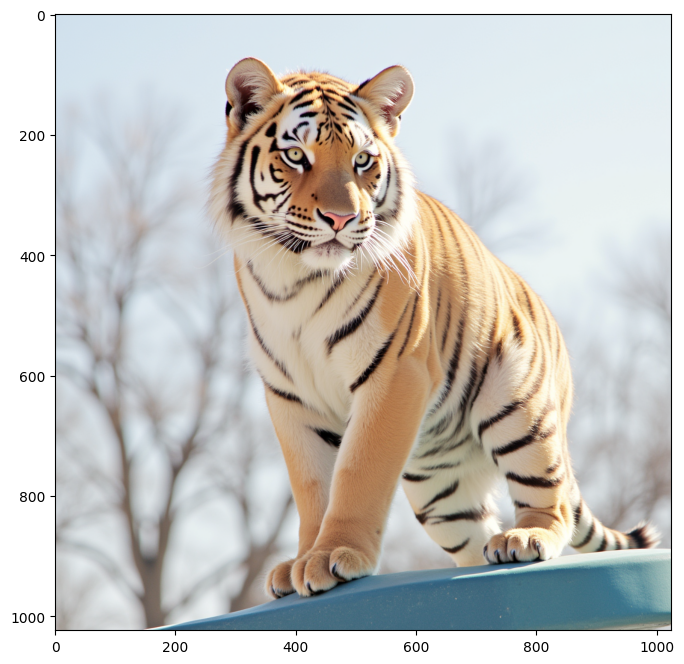

In [10]:
img = decode_imgs(img_latent_denoised, pipe)[0]

plt.figure(figsize=(8, 8))
plt.imshow(img)